In [1]:
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

import vapor
from vapor.models import Cambium

2021-01-20 06:27:35,928 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['adjusted_installed_cost']
scenarios = ['StdScen20_MidCase']
techs = ['wind','pv']
constraints = ['hourly_energy','annual_recs']
constraint_pcts = [25,50,75,95]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for constraint in constraints:
                for constraint_pct in constraint_pcts:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_constraint_{constraint}_{constraint_pct}.pkl"
                    fp = os.path.join('results',file)
                    df = pd.read_pickle(fp)
                    df['goal_type'] = constraint
                    df['goal_pct'] = constraint_pct
                    dfs.append(df)


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by State ---
df.sort_values(opt_vars[0], inplace=True)

results['lifetime_cambium_co2_rate_avg_mwh'] = results['lifetime_cambium_co2_rate_avg'] / results['lifetime_output_mwh']
results['lifetime_cambium_co2_rate_lrmer_mwh'] = results['lifetime_cambium_co2_rate_lrmer'] / results['lifetime_output_mwh']


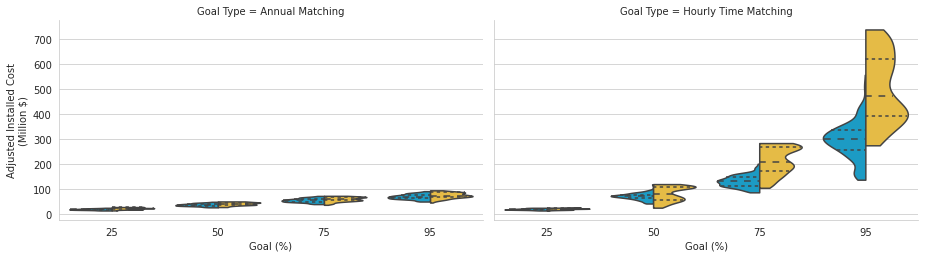

In [4]:
import seaborn as sns
sns.set_style('whitegrid')

data = df[['region','tech','goal_type','goal_pct', 'adjusted_installed_cost']]
data['adjusted_installed_cost'] /= 1000000

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'adjusted_installed_cost'].quantile(0.75)
        datas.append(data.loc[goal_mask & (data['adjusted_installed_cost'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual Matching'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','adjusted_installed_cost']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

sns.set_palette(sns.color_palette([vapor.tech_dict['wind'], vapor.tech_dict['pv']]))

g = sns.catplot(x='goal_pct', y='adjusted_installed_cost',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True,
               height=3.5, aspect=1.8, cut=0, scale='width', legend=False)

# g.set(ylim=(0,600))
g.set_xlabels('Goal (%)')
g.set_ylabels('Adjusted Installed Cost\n(Million $)')

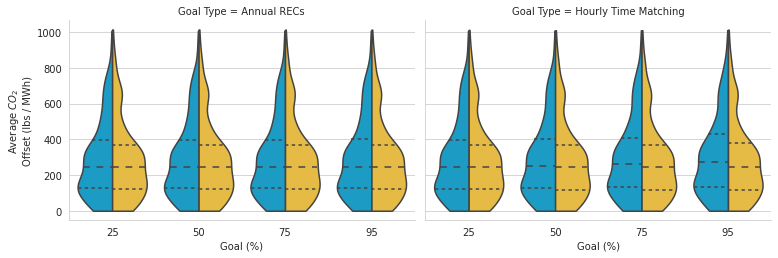

In [5]:
import seaborn as sns
sns.set_style('whitegrid')

data = df[['region','tech','goal_type','goal_pct', 'lifetime_cambium_co2_rate_avg_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'lifetime_cambium_co2_rate_avg_mwh'].quantile(1)
        datas.append(data.loc[goal_mask & (data['lifetime_cambium_co2_rate_avg_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','lifetime_cambium_co2_rate_avg_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

sns.set_palette(sns.color_palette([vapor.tech_dict['wind'], vapor.tech_dict['pv']]))

g = sns.catplot(x='goal_pct', y='lifetime_cambium_co2_rate_avg_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.5, cut=0, scale='width')

# g.set(ylim=(0,600))
g.set_xlabels('Goal (%)')
g.set_ylabels('Average $CO_2$\nOffset (lbs / MWh)')

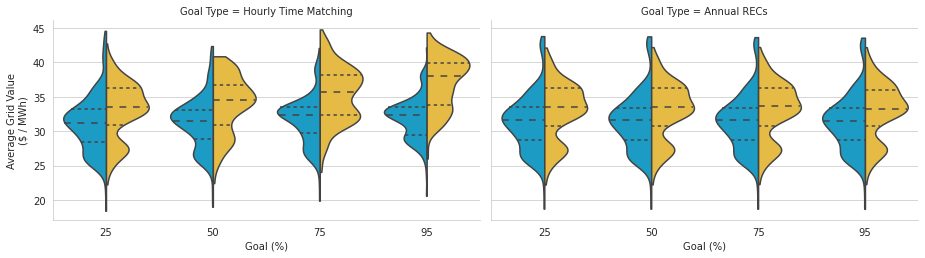

In [33]:
import seaborn as sns
sns.set_style('whitegrid')

data = df[['region','tech','goal_type','goal_pct', 'grid_value_per_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'grid_value_per_mwh'].quantile(1)
        datas.append(data.loc[goal_mask & (data['grid_value_per_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','grid_value_per_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['Wind','PV'])

sns.set_palette(sns.color_palette([vapor.tech_dict['wind'], vapor.tech_dict['pv']]))

g = sns.catplot(x='goal_pct', y='grid_value_per_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.8, cut=0, scale='width')

# g.set(ylim=(0,600))
g.set_xlabels('Goal (%)')
g.set_ylabels('Average Grid Value\n($ / MWh)')

In [32]:
data = df[['region','tech','goal_type','goal_pct', 'marginal_cost_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'marginal_cost_mwh'].quantile(0.95)
        datas.append(data.loc[goal_mask & (data['marginal_cost_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','marginal_cost_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['PV', 'Wind'])

data.groupby(['Tech', 'Goal Type', 'goal_pct'], 
             as_index=False)['marginal_cost_mwh'].apply(lambda x: x.quantile([q/100 for q in range(0,101) if q %25 ==0]))

Tech      Goal Type  goal_pct        0.0  \
Tech Goal Type     goal_pct                                             
PV   annual_recs   25          PV    annual_recs        25  12.443897   
                   50          PV    annual_recs        50  12.246146   
                   75          PV    annual_recs        75  12.182117   
                   95          PV    annual_recs        95  12.218790   
     hourly_energy 25          PV  hourly_energy        25  12.622881   
                   50          PV  hourly_energy        50  18.948315   
                   75          PV  hourly_energy        75  40.225998   
                   95          PV  hourly_energy        95  40.771401   
Wind annual_recs   25        Wind    annual_recs        25   9.851202   
                   50        Wind    annual_recs        50  10.238000   
                   75        Wind    annual_recs        75  10.364262   
                   95        Wind    annual_recs        95  10.454260   
     hourly_energy 25        Wind  hourly_energy        25   9.309314   
                   50        Wind  hourly_energy        50   9.654567   
                   75        Wind  hourly_energy        75  24.533180   
                   95        Wind  hourly_energy        95  24.084692   

                                  0.25        0.5       0.75        1.0  
Tech Goal Type     goal_pct                                              
PV   annual_recs   25        17.077505  19.289922  22.276192  38.609519  
                   50        16.786515  18.944809  22.098641  38.199267  
                   75        16.696957  18.834604  21.437828  37.823073  
                   95        16.643710  18.833314  21.363356  37.832106  
     hourly_energy 25        17.029522  19.373523  22.048998  40.754040  
                   50        34.566048  40.382974  48.561022  75.894949  
                   75        54.826841  58.800533  64.925960  73.909731  
                   95        50.939994  55.805251  60.027129  77.998965  
Wind annual_recs   25        22.865903  28.084890  36.708028  57.771982  
                   50        22.735160  28.213790  36.504403  57.675500  
                   75        22.700933  28.320621  37.064798  58.487737  
                   95        22.679992  28.167190  38.608110  58.276258  
     hourly_energy 25        23.419708  29.310402  39.852322  76.081033  
                   50        31.864660  48.536632  65.893256  86.191200  
                   75        44.293299  50.771073  64.489860  94.633245  
                   95        48.586214  61.353773  69.583750  96.882360

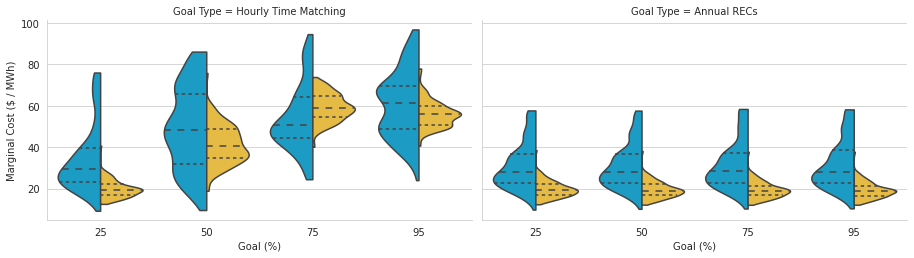

In [28]:
import seaborn as sns
sns.set_style('whitegrid')

data = df[['region','tech','goal_type','goal_pct', 'marginal_cost_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'marginal_cost_mwh'].quantile(0.95)
        datas.append(data.loc[goal_mask & (data['marginal_cost_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','marginal_cost_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['Wind','PV'])

sns.set_palette(sns.color_palette([vapor.tech_dict['wind'], vapor.tech_dict['pv']]))

g = sns.catplot(x='goal_pct', y='marginal_cost_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.8, cut=0, scale='width')

# g.set(ylim=(0,600))
g.set_xlabels('Goal (%)')
g.set_ylabels('Marginal Cost ($ / MWh)')

In [43]:
df[['desired_capacity', 'desired_power', 'batt_bank_installed_capacity']].apply(lambda x: x.quantile([q/100 for q in range(0,101) if q % 10 == 0]))

,desired_capacity,desired_power,batt_bank_installed_capacity
0.0,0.000000e+00,0.000000e+00,0.000000e+00
0.1,3.000000e+00,0.000000e+00,3.814470e+04
0.2,2.555843e+03,6.389608e+02,6.962476e+04
0.3,5.755675e+04,1.438919e+04,1.238918e+05
0.4,9.844519e+04,2.461130e+04,1.636057e+05
0.5,1.570618e+05,3.926544e+04,2.063223e+05
0.6,2.136759e+05,5.341898e+04,3.180701e+05
0.7,3.360146e+05,8.400366e+04,4.113176e+05
0.8,4.481580e+05,1.120395e+05,5.158288e+05
0.9,8.401031e+05,2.100258e+05,1.124756e+06


In [50]:
grouped = results.groupby(['tech','goal_type','goal_pct'], as_index=False)\
                [['adjusted_installed_cost','annual_energy','marginal_cost_mwh','grid_value_per_mwh','lifetime_cambium_co2_rate_lrmer_mwh']].mean()
grouped.goal_type = pd.Categorical(grouped.goal_type, ['annual_recs','hourly_energy'])
grouped.tech = pd.Categorical(grouped.tech, ['pv','wind'])

grouped.sort_values(['goal_type','tech','goal_pct'], inplace=True)
grouped[['adjusted_installed_cost','annual_energy']] /= 1e6

rename_dict = {'hourly_energy':'Hourly Energy', 'annual_recs':'Annual RECs'}
grouped['goal_type'] = grouped['goal_type'].map(rename_dict)
tech_dict = {'pv':'PV', 'wind':'Wind'}
grouped['tech'] = grouped['tech'].map(tech_dict)

grouped.columns = ['Tech', 'Goal Type', 'Goal %', 'Adjusted Installed Cost (mill. $)','Annual Energy Production (GWh)','Marginal Cost ($/MWh)', 'Grid Value ($/MWh)','Avoided CO2 (lbs / MWh)']
grouped = grouped[['Goal Type','Goal %', 'Tech','Annual Energy Production (GWh)', 'Adjusted Installed Cost (mill. $)','Marginal Cost ($/MWh)', 'Grid Value ($/MWh)','Avoided CO2 (lbs / MWh)']]
grouped.to_csv(os.path.join('images','constraint_table.csv'))
grouped


,Goal Type,Goal %,Tech,Annual Energy Production (GWh),Adjusted Installed Cost (mill. $),Marginal Cost ($/MWh),Grid Value ($/MWh),Avoided CO2 (lbs / MWh)
0,Annual RECs,25,PV,24.985871,18.657431,19.677992,32.819141,290.186451
1,Annual RECs,50,PV,49.794408,36.713477,19.422136,32.846413,290.239654
2,Annual RECs,75,PV,74.567410,54.683473,19.285528,32.883395,290.177354
3,Annual RECs,95,PV,94.372774,68.897466,19.170380,32.862645,290.294870
8,Annual RECs,25,Wind,27.203150,28.502998,36.114727,30.896661,369.135081
9,Annual RECs,50,Wind,52.201468,54.688761,36.384084,30.910428,369.195097
10,Annual RECs,75,Wind,77.265663,80.709152,36.847149,30.905383,369.239645
11,Annual RECs,95,Wind,97.075456,100.908197,37.006596,30.881771,369.245940
4,Hourly Energy,25,PV,26.021042,19.521506,19.698309,32.889801,290.117881
5,Hourly Energy,50,PV,61.321707,69.338714,41.228841,33.751784,299.067644


In [51]:
system_configs = df[['state','tech','goal_type','goal_pct','adjusted_installed_cost',
                         'system_capacity',
                          'turbine_class','wind_turbine_hub_ht',
                          'subarray1_azimuth','subarray1_tilt',
                          'dc_ac_ratio',
                          'desired_power','desired_capacity']]
system_configs['batt_duration'] = system_configs['desired_capacity'] / system_configs['desired_power']

states = system_configs.copy()
states = states.loc[states['state'].isin(['CA','TX'])]
states = states.loc[states['goal_type'] == 'hourly_energy']
states.sort_values(['state','goal_pct','adjusted_installed_cost'], inplace=True, ascending=True)
states.drop_duplicates(subset=['state','goal_pct'], inplace=True)

states['adjusted_installed_cost'] /= 1e6
states[['system_capacity','desired_capacity','desired_power']] /= 1e3
states.to_csv(os.path.join('images','best_systems_table.csv'))
states

,state,tech,goal_type,goal_pct,adjusted_installed_cost,system_capacity,turbine_class,wind_turbine_hub_ht,subarray1_azimuth,subarray1_tilt,dc_ac_ratio,desired_power,desired_capacity,batt_duration
2853,CA,pv,hourly_energy,25,15.084981,10.133777,NaN,NaN,181.589913,41.238905,1.173685,0.000000e+00,3.000000e-03,inf
3208,CA,pv,hourly_energy,50,41.730832,19.873309,NaN,NaN,178.256548,35.155864,1.199595,8.213006e+00,3.285202e+01,4.0
3563,CA,pv,hourly_energy,75,90.546764,35.996174,NaN,NaN,182.018054,34.806491,1.198061,2.488855e+01,9.955419e+01,4.0
3922,CA,pv,hourly_energy,95,139.991039,46.736803,NaN,NaN,180.854135,35.542936,1.199906,4.707532e+01,1.883013e+02,4.0
247,TX,wind,hourly_energy,25,12.648580,7.356297,6.0,98.366458,NaN,NaN,NaN,0.000000e+00,3.000000e-03,inf
604,TX,wind,hourly_energy,50,24.880825,16.325532,6.0,98.252278,NaN,NaN,NaN,3.841033e-12,1.536413e-11,4.0
3803,TX,pv,hourly_energy,75,86.233875,33.893458,NaN,NaN,181.838446,31.846750,1.198729,2.885257e+01,1.154103e+02,4.0
4159,TX,pv,hourly_energy,95,136.721709,53.669319,NaN,NaN,180.467618,32.284833,1.199324,4.597417e+01,1.838967e+02,4.0


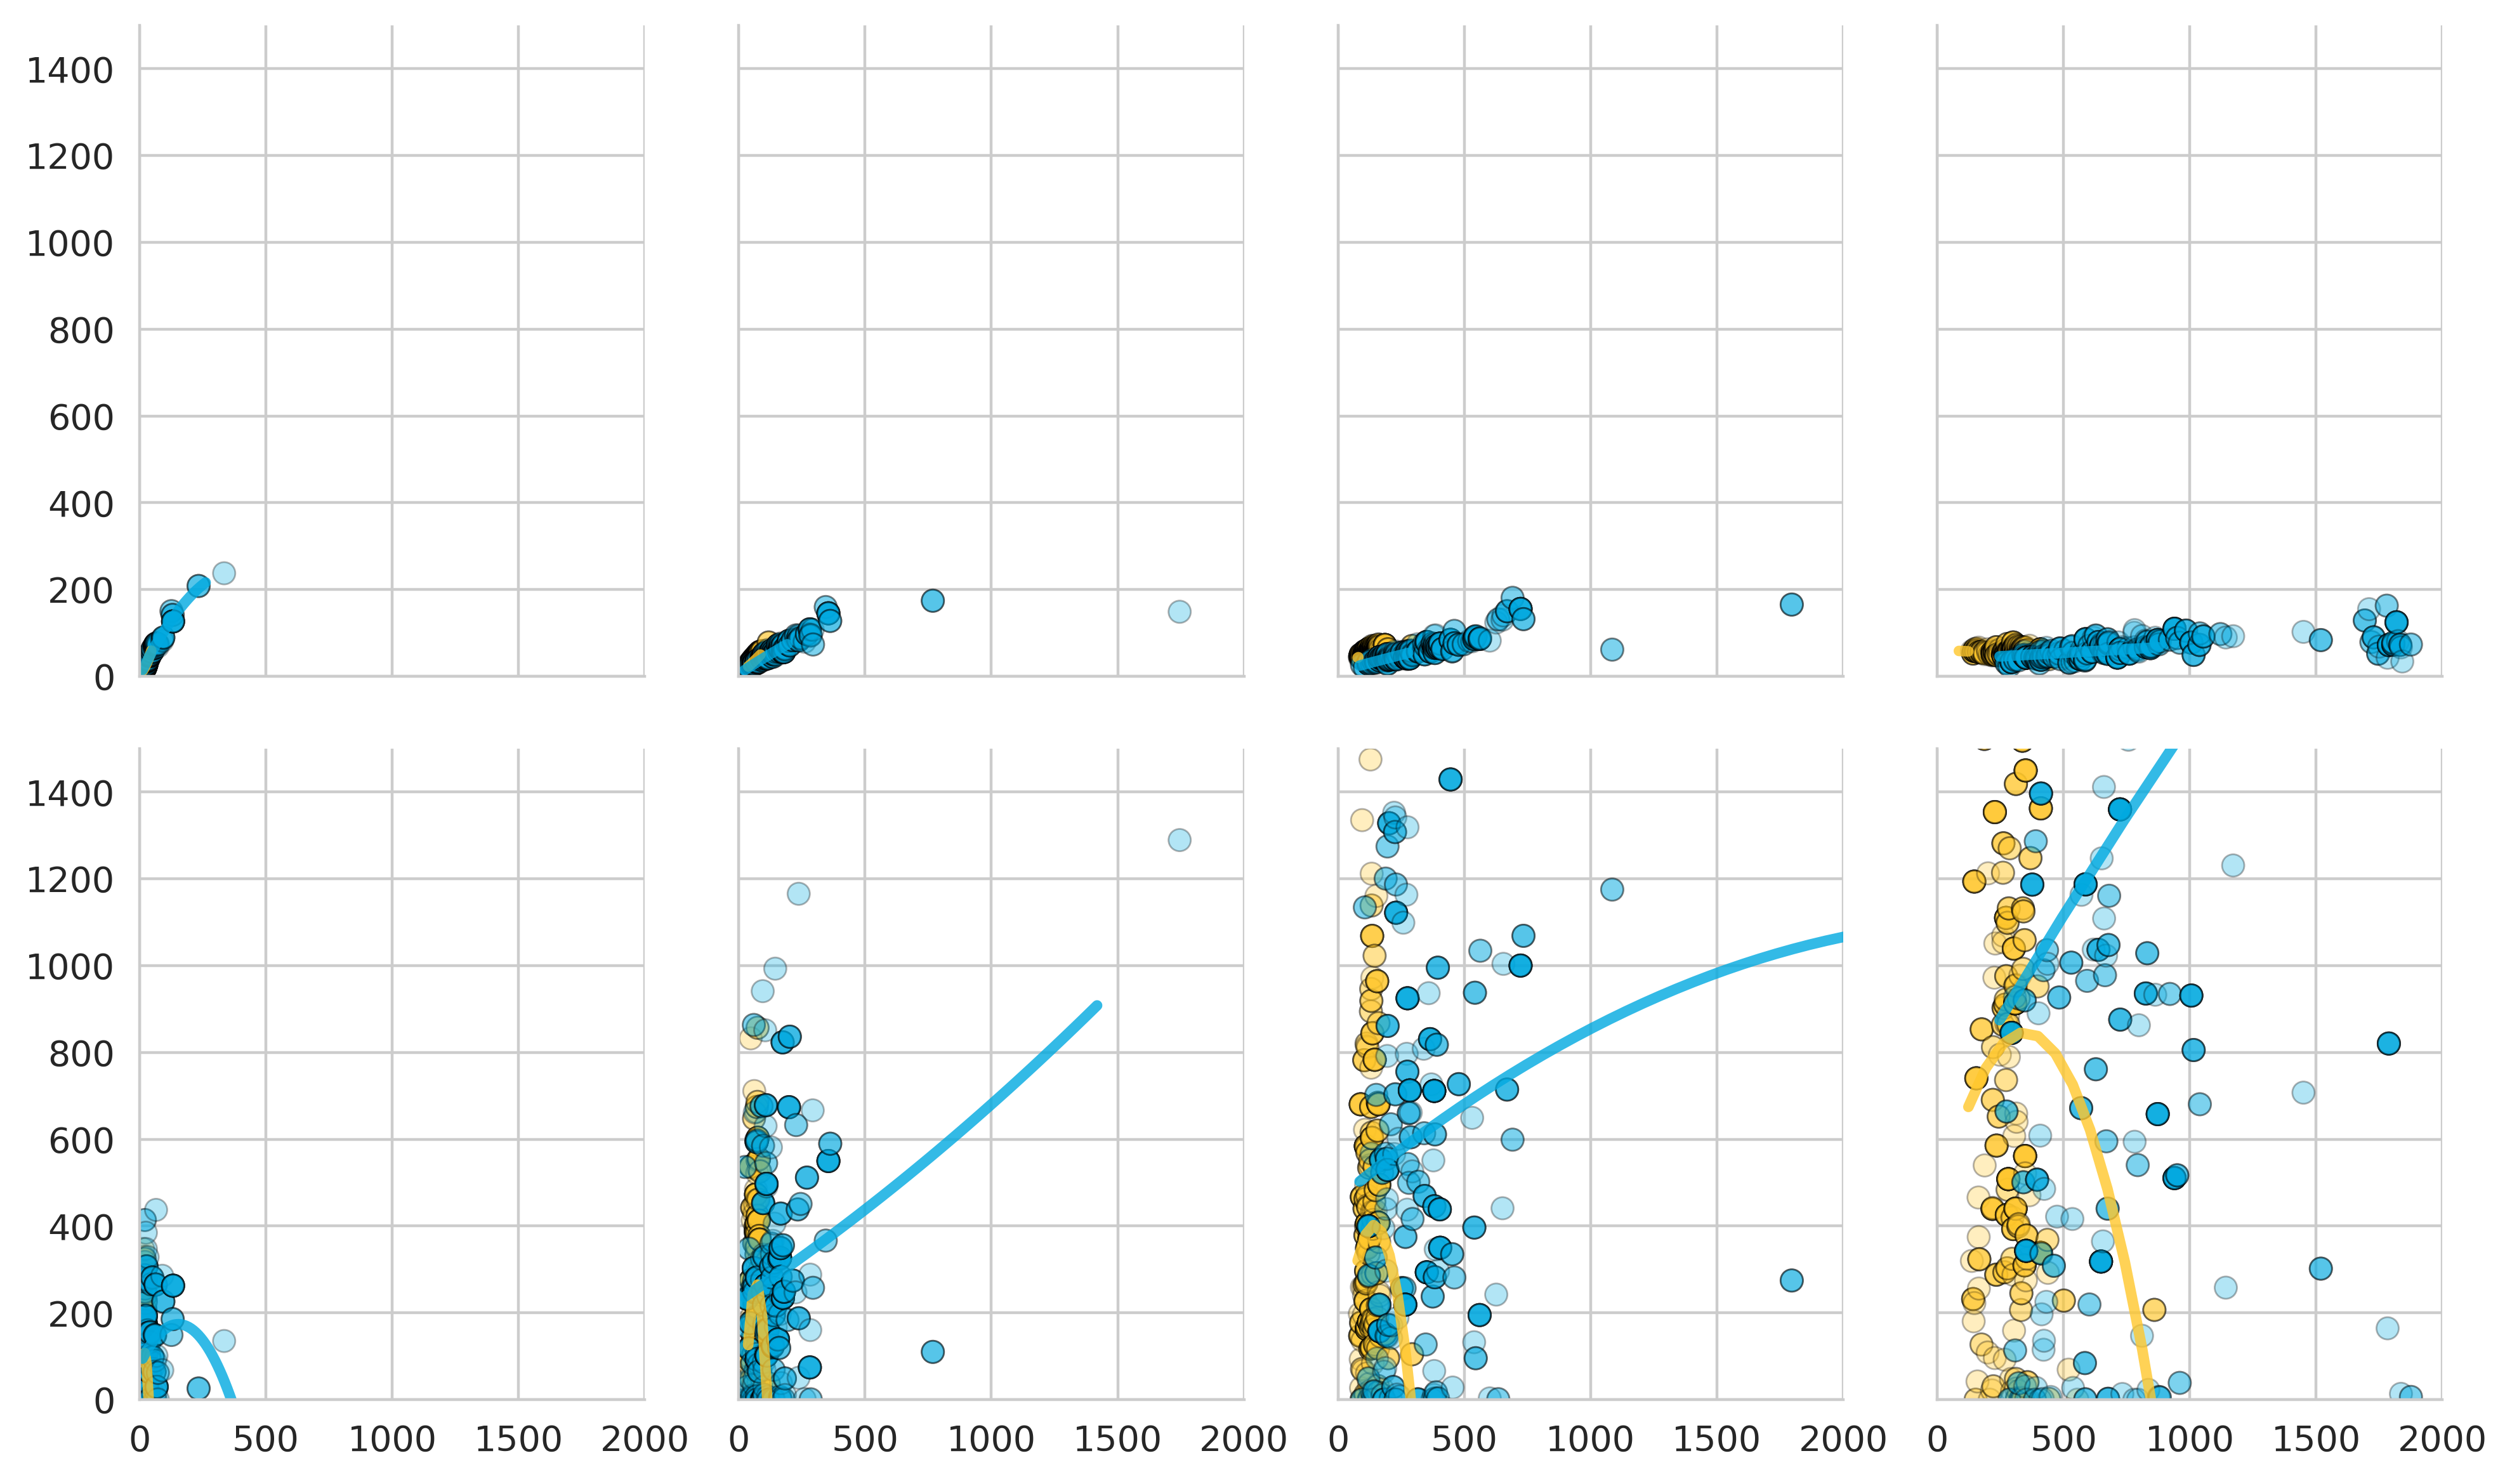

In [20]:

import numpy as np

data = df[['region','tech','goal_type','goal_pct',
                'adjusted_installed_cost','lifetime_cambium_co2_rate_avg','marginal_cost_mwh']]
data['adjusted_installed_cost'] /= 1000000
data['lifetime_cambium_co2_rate_avg'] /= 1000000
data = data.loc[data['goal_type'] == 'hourly_energy']

sns.set_style()
fig, axs = plt.subplots(figsize=(10,6), nrows=2, ncols=4, sharey=True, sharex=True, dpi=400)

goal_pct_dict = {25:'s', 50:'o', 75:'P', 95:'^'}

nrel_color_dict = ['#0077C8', #darkblue
                '#00A9E0', #lightblue
                '#658D1B', #darkgreen
                '#84BD00', #lightgreen
                '#FFC72C', #yellow
                '#DE7C00', #orange
                '#5B6770', #darkgray
                '#C1C6C8'] #lightgray

tech_dict = {'pv':nrel_color_dict[4],
            'wind':nrel_color_dict[1],
            'batt':nrel_color_dict[3]}


for i_tech, tech in enumerate(['pv','wind']):
    for col, goal_pct in enumerate([25,50,75,95]):
        scenario_df = data.loc[(data['goal_pct'] == goal_pct) & (data['tech'] == tech)]
#         scenario_df = data.loc[(data['goal_type'] == goal_type) & (data['tech'] == tech)]

        colors = scenario_df['tech'].map(tech_dict)
        
        x_col = 'adjusted_installed_cost'
        for row, y_col in enumerate(['marginal_cost_mwh', 'lifetime_cambium_co2_rate_avg']):
            axs[row][col].scatter(
                    x=scenario_df[x_col],
                    y=scenario_df[y_col],
                    s=40,
                    c=colors,
                    alpha=0.3, edgecolor="k", linewidth=0.5)

            poly = np.poly1d(np.polyfit(scenario_df[x_col], scenario_df[y_col], 2))
            x_min = scenario_df[x_col].min() * 0.9
            x_max = scenario_df[y_col].max() * 1.1
            x_range = np.linspace(x_min, x_max, 50)
            axs[row][col].plot(
                        x_range, poly(x_range),
                        c=tech_dict[tech], linewidth=3, alpha=0.8)
            
#             axs[row][col].set(
#                 xlim=(scenario_df[x_col].min(), scenario_df[x_col].quantile(0.75)),
#                 ylim=(0,scenario_df[y_col].quantile(0.75))
#             )
            
#             if col == 0:
#                 axs[row][col].set_ylabel(y_col)

#         if i_scenario == 0:
#             axs[i_tech][i_scenario].set_ylabel('Lifetime Cumulative \n Grid Value')

#         if i_tech == 1:
#             axs[i_tech][i_scenario].set_xlabel('Marginal Cost ($/MWh)')

#         if i_tech ==0:
#             axs[i_tech][i_scenario].set_title(scen_label_dict[s])
#             axs[i_tech][i_scenario].get_xaxis().set_visible(False)

axs[0][0].set_ylim(0, 100)
axs[1][0].set_ylim(0, 1500)

axs[0][0].set_xlim(0,2000)
axs[0][1].set_xlim(0,2000)
axs[0][2].set_xlim(0,2000)
axs[0][3].set_xlim(0,2000)

# if legend:
#     solar_handles, solar_labels = axs[i_tech-1][i_scenario].get_legend_handles_labels()
#     wind_handles, wind_labels = axs[i_tech][i_scenario].get_legend_handles_labels()
#     fig.legend(solar_handles+wind_handles, solar_labels+wind_labels, bbox_to_anchor=(1.2, 1))

sns.despine()
plt.tight_layout()

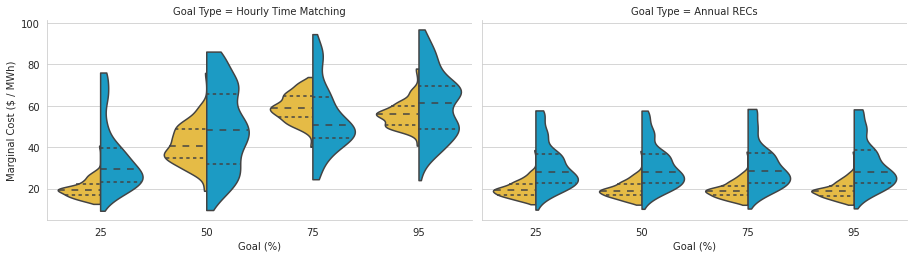

In [10]:
import seaborn as sns
sns.set_style('whitegrid')

data = df[['region','tech','goal_type','goal_pct', 'marginal_cost_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'marginal_cost_mwh'].quantile(0.95)
        datas.append(data.loc[goal_mask & (data['marginal_cost_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','marginal_cost_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['PV','Wind'])

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

g = sns.catplot(x='goal_pct', y='marginal_cost_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.8, cut=0, scale='width')

# g.set(ylim=(0,600))
g.set_xlabels('Goal (%)')
g.set_ylabels('Marginal Cost ($ / MWh)')

In [12]:
data.groupby(['Goal Type', 'Tech', 'goal_pct'], as_index=False)['marginal_cost_mwh'].apply(lambda x: x.quantile([.25, .5, .75]))

,Goal Type,Tech,goal_pct,0.25,0.5,0.75
0,Hourly Time Matching,PV,25,17.029522,19.373523,22.048998
1,Hourly Time Matching,PV,50,34.566048,40.382974,48.561022
2,Hourly Time Matching,PV,75,54.826841,58.800533,64.925960
3,Hourly Time Matching,PV,95,50.939994,55.805251,60.027129
4,Hourly Time Matching,Wind,25,23.419708,29.310402,39.852322
5,Hourly Time Matching,Wind,50,31.864660,48.536632,65.893256
6,Hourly Time Matching,Wind,75,44.293299,50.771073,64.489860
7,Hourly Time Matching,Wind,95,48.586214,61.353773,69.583750
8,Annual RECs,PV,25,17.077505,19.289922,22.276192
9,Annual RECs,PV,50,16.786515,18.944809,22.098641


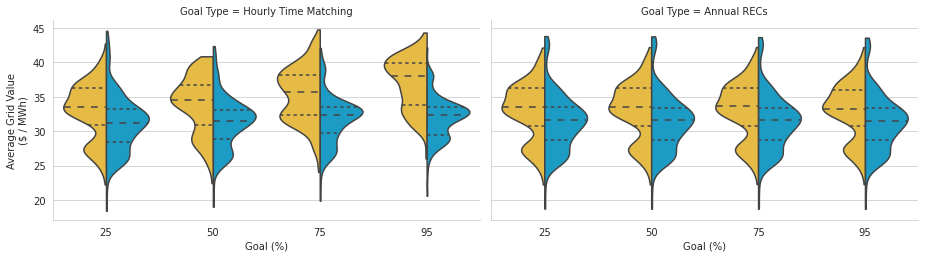

In [15]:
import seaborn as sns
sns.set_style('whitegrid')

data = df[['region','tech','goal_type','goal_pct', 'grid_value_per_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'grid_value_per_mwh'].quantile(1)
        datas.append(data.loc[goal_mask & (data['grid_value_per_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','grid_value_per_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['PV', 'Wind'])

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

g = sns.catplot(x='goal_pct', y='grid_value_per_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.8, cut=0, scale='width')

# g.set(ylim=(0,600))
g.set_xlabels('Goal (%)')
g.set_ylabels('Average Grid Value\n($ / MWh)')

In [16]:
data.groupby(['Goal Type', 'Tech', 'goal_pct'], as_index=False)['grid_value_per_mwh'].apply(lambda x: x.quantile([.25, .5, .75]))

,Goal Type,Tech,goal_pct,0.25,0.5,0.75
0,Hourly Time Matching,PV,25,30.983001,33.501774,36.251727
1,Hourly Time Matching,PV,50,30.953127,34.601834,36.771129
2,Hourly Time Matching,PV,75,32.362722,35.774326,38.247482
3,Hourly Time Matching,PV,95,33.810277,38.088970,39.930873
4,Hourly Time Matching,Wind,25,28.473245,31.261064,33.205071
5,Hourly Time Matching,Wind,50,28.908819,31.491691,33.131030
6,Hourly Time Matching,Wind,75,29.758027,32.386109,33.475747
7,Hourly Time Matching,Wind,95,29.467503,32.354573,33.525013
8,Annual RECs,PV,25,30.745327,33.494967,36.217337
9,Annual RECs,PV,50,30.748432,33.532728,36.217811


In [19]:
len(data.region.unique())

134

### 